## Clasificación

In [1]:
from matplotlib import pyplot as plt ## graficar
import numpy as np ### operar vectores
import pandas as pd #### manejar dataframes
from sklearn.preprocessing import PolynomialFeatures, StandardScaler ### preprocesar los datos
from sklearn.model_selection import cross_val_score #### NO SE USA
from sklearn.model_selection import GridSearchCV #### Validación cruzada
import warnings
warnings.filterwarnings("ignore")

In [2]:
#leer datos
path = '/home/rho/gdrive/Personales/Robert/Santoto/20211/Maestria_DM_ML/02_Semana2/'
datos = pd.read_csv(path + 'base_logistica.csv', header=None, names = ('med1','med2','clase'))
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   med1    118 non-null    float64
 1   med2    118 non-null    float64
 2   clase   118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


In [3]:
datos.head()

,med1,med2,clase
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [4]:
## separar predictores y variable respuesta
X = datos.drop(columns = 'clase')
y = datos.clase.values

## Estandarizar los datos
sc = StandardScaler() ### incializar
sc.fit(X) ## ajusta a los valores de x : sklearn
X_std = sc.transform(X)

In [5]:
X_std[:6]

array([[-0.00710129,  0.99791805],
       [-0.29829632,  0.9696688 ],
       [-0.54290103,  0.98379343],
       [-0.8690393 ,  0.61655322],
       [-1.14858928,  0.5459301 ],
       [-1.17188342,  0.05158761]])

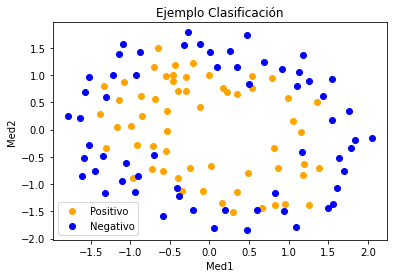

In [6]:
# gráfica de información
plt.scatter(X_std[y == 1,0], X_std[y == 1,1], c='orange', label='Positivo')
plt.scatter(X_std[y == 0,0], X_std[y == 0,1], c='blue', label='Negativo')
plt.xlabel("Med1")
plt.ylabel("Med2")
plt.title('Ejemplo Clasificación')
plt.legend()

In [4]:
# región de clasificación
def plot_boundary(clf, X, grid_step=.01, mat_poly = None):
    #X: numpy array
    #y: numpy array
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    if mat_poly:
        Z = clf.predict(mat_poly.transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z.reshape(xx.shape)
    else:
        Z = clf.predict(np.array([xx.ravel(), xx.ravel()]).T)
        Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha = 0.3)

In [61]:
X.shape

(118, 2)

# Regresión logística sobre los datos estandarizados

In [62]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(random_state=123456) ## inicializar
logit.fit(X_std, y) ### aplico el metodo fit (ajustar la regresión logística a los datos)
y_pred = logit.predict(X_std)

In [63]:
y_pred

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0])

In [64]:
(y_pred != y).sum()

53

In [65]:
## Esperanza del error de predicción
error = (y_pred != y).sum()/len(y)
print('El error de predicción es: ', np.round(error*100,2), '%')
print('La precisión de la predicción es: ', np.round((1-error)*100,2), '%')

El error de predicción es:  44.92 %
La precisión de la predicción es:  55.08 %


In [66]:
## Precisión de la clasificación por scikit-learn
from sklearn.metrics import accuracy_score, roc_auc_score
print('Accuracy: %.2f' % np.round(accuracy_score(y_pred, y)*100,2), '%')

Accuracy: 55.08 %


In [67]:
# matriz de confusión
pd.crosstab(y, y_pred)

col_0,0,1
row_0,,
0,35,25
1,28,30


In [68]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, y_pred)

array([[35, 25],
       [28, 30]])

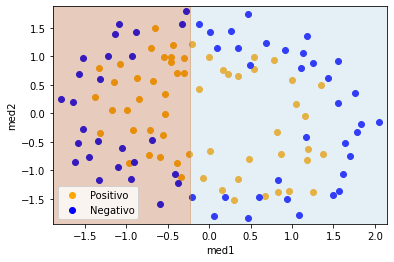

In [69]:
# Región de decisión para la regresión logística sobre los datos estandarizados
plt.scatter(X_std[y == 1,0], X_std[y == 1,1], c='orange', label='Positivo')
plt.scatter(X_std[y == 0,0], X_std[y == 0,1], c='blue', label='Negativo')
plot_boundary(logit, X_std, grid_step=.01) # dibujo la región de clasificación
plt.xlabel("med1")
plt.ylabel("med2")
plt.legend()

# Flexibilizar el modelo aumentando la dimensionalidad

Para aumentar la dimensionalidad del espacio de predictores, se deben tener en cuenta las interacciones polinomiales según la cantidad de variables en el conjunto de predictores de la siguiente manera:

$$\large \{x_1^d, x_1^{d-1}x_2, \ldots x_2^d\} =  \{x_1^ix_2^j\}_{i+j=d, i,j \in \mathbb{N} }$$

Entonces, para $d = 2$ se tiene:

$$\large 1, x_1, x_2,  x_1^2, x_1x_2, x_2^2$$

Para $d = 3$ se tiene:

$$\large 1, x_1, x_2,  x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$$

**sklearn** dispone de una función para realizar esta expansión polinomial mediante el módulo *PolynomialFeatures*.


In [70]:
poly = PolynomialFeatures(degree=2) #Generar interacciones polinomiales... probar con2, 3, 5, 10, 15, 20, 22
X_poly = poly.fit_transform(X_std)

In [71]:
X_poly[:6]

array([[ 1.00000000e+00, -7.10129423e-03,  9.97918051e-01,
         5.04283798e-05, -7.08650970e-03,  9.95840438e-01],
       [ 1.00000000e+00, -2.98296321e-01,  9.69668805e-01,
         8.89806949e-02, -2.89248637e-01,  9.40257591e-01],
       [ 1.00000000e+00, -5.42901033e-01,  9.83793428e-01,
         2.94741531e-01, -5.34102468e-01,  9.67849509e-01],
       [ 1.00000000e+00, -8.69039300e-01,  6.16553221e-01,
         7.55229306e-01, -5.35808980e-01,  3.80137874e-01],
       [ 1.00000000e+00, -1.14858928e+00,  5.45930104e-01,
         1.31925732e+00, -6.27049463e-01,  2.98039678e-01],
       [ 1.00000000e+00, -1.17188342e+00,  5.15876086e-02,
         1.37331075e+00, -6.04546633e-02,  2.66128136e-03]])

In [72]:
logit2 = LogisticRegression(random_state=123456)
logit2.fit(X_poly, y)
y_pred = logit2.predict(X_poly)

In [73]:
print('Accuracy: %.2f' % np.round(accuracy_score(y_pred, y)*100,2), '%')

Accuracy: 83.90 %


Accuracy sobre los datos de entrenamiento: 0.839


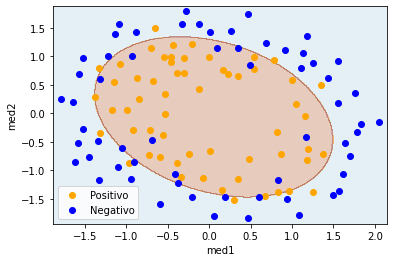

In [19]:
plot_boundary(logit2, X_std, grid_step=.01, mat_poly=poly)

plt.scatter(X_std[y == 1,0], X_std[y == 1,1], c='orange', label='Positivo')
plt.scatter(X_std[y == 0,0], X_std[y == 0,1], c='blue', label='Negativo')
plt.xlabel("med1")
plt.ylabel("med2")
plt.legend()

print("Accuracy sobre los datos de entrenamiento:", round(logit2.score(X_poly, y), 3))

AUC: 0.92


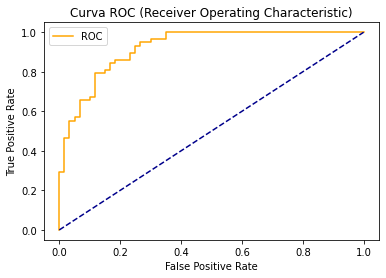

In [76]:
### Graficando Curva ROC
# importar funciones
from sklearn.metrics import roc_curve, roc_auc_score

# predecir las probabilidades para el hold-out
probs = logit2.predict_proba(X_poly)
# Mantener las probabilidades de la clase positiva (1)
probs = probs[:, 1]
# Calcular el AUC (Área bajo la curva ROC)
auc = roc_auc_score(y, probs)
print('AUC: %.2f' % auc)
# Obtener la curva ROC
fpr, tpr, umbral = roc_curve(y, probs)
# Graficar la curva ROC
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend()
plt.show()

In [77]:
%matplotlib inline
from ipywidgets import * ###  nodejs

def poly_plot(d = 10):
    poly = PolynomialFeatures(degree = int(d)) #Generar interacciones polinomiales... probar con2, 3, 5, 10, 15, 20, 22
    X_poly = poly.fit_transform(X_std)
    logit2 = LogisticRegression(random_state=123456)
    logit.fit(X_poly, y)
    y_pred = logit.predict(X_poly)
    print('Accuracy: %.2f' % np.round(accuracy_score(y_pred, y)*100,2), '%')
    plot_boundary(logit, X_std, grid_step=.01, mat_poly=poly)
    plt.scatter(X_std[y == 1,0], X_std[y == 1,1], c='orange', label='Positivo')
    plt.scatter(X_std[y == 0,0], X_std[y == 0,1], c='blue', label='Negativo')
    plt.xlabel("med1")
    plt.ylabel("med2")
    plt.legend()

interact(poly_plot, d = widgets.FloatSlider(value=1, min=1, max=20, step=1, readout_format='.0f'))

interactive(children=(FloatSlider(value=1.0, description='d', max=20.0, min=1.0, readout_format='.0f', step=1.…

<function __main__.poly_plot(d=10)>

# Flexibilizar el modelo con el parámetro de regularización

### opción modelo simple

In [78]:
c = 10 ## probar con 0.05, 1, 5, 10
logit = LogisticRegression(C = c, random_state=123456) #inicializar
logit.fit(X_std, y)
y_pred = logit.predict(X_std)
print('Accuracy: %.2f' % np.round(accuracy_score(y_pred, y)*100,2), '%')

Accuracy: 55.08 %


Accuracy sobre los datos de entrenamiento: 0.551


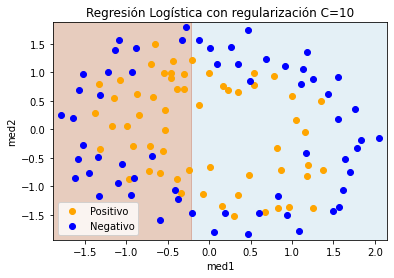

In [79]:
plot_boundary(logit, X_std, grid_step=.01)
plt.scatter(X_std[y == 1,0], X_std[y == 1,1], c='orange', label='Positivo')
plt.scatter(X_std[y == 0,0], X_std[y == 0,1], c='blue', label='Negativo')
plt.xlabel("med1")
plt.ylabel("med2")
plt.title('Regresión Logística con regularización C=%s' % c)
plt.legend()

print("Accuracy sobre los datos de entrenamiento:", round(logit.score(X_std, y), 3))

In [81]:
%matplotlib inline

def c_plot(c = 0.01):
    logit = LogisticRegression(C = c, random_state=123456)
    logit.fit(X_std, y)
    y_pred = logit.predict(X_std)
    print('Accuracy: %.2f' % np.round(accuracy_score(y_pred, y)*100,2), '%')
    plot_boundary(logit, X_std, grid_step=.01)
    plt.scatter(X_std[y == 1,0], X_std[y == 1,1], c='orange', label='Positivo')
    plt.scatter(X_std[y == 0,0], X_std[y == 0,1], c='blue', label='Negativo')
    plt.xlabel("med1")
    plt.ylabel("med2")
    plt.legend()

interact(c_plot, c = widgets.FloatSlider(value=0.01, min=0.01, max=0.5, step=0.00001, readout_format='.3f'))


interactive(children=(FloatSlider(value=0.01, description='c', max=0.5, min=0.01, readout_format='.3f', step=1…

<function __main__.c_plot(c=0.01)>

In [82]:
poly = PolynomialFeatures(degree=6) #Generar interacciones polinomiales... probar con2, 3, 5, 10, 15, 20, 22
X_poly = poly.fit_transform(X_std)

In [84]:
C = 100 ## probar con 0.05, 1, 50, 100
logit3 = LogisticRegression(C=C, random_state=123456)
logit3.fit(X_poly, y)
y_pred = logit3.predict(X_poly)
print('Accuracy: %.2f' % np.round(accuracy_score(y_pred, y)*100,2), '%')

Accuracy: 86.44 %


In [87]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1])

Accuracy sobre los datos de entrenamiento: 0.864


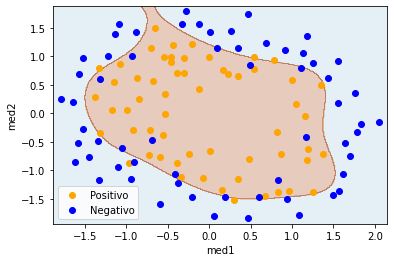

In [85]:
plot_boundary(logit3, X_std, grid_step=.01, mat_poly=poly)
plt.scatter(X_std[y == 1,0], X_std[y == 1,1], c='orange', label='Positivo')
plt.scatter(X_std[y == 0,0], X_std[y == 0,1], c='blue', label='Negativo')
plt.xlabel("med1")
plt.ylabel("med2")
plt.legend()

print("Accuracy sobre los datos de entrenamiento:", round(logit.score(X_poly, y), 3))

In [86]:
%matplotlib inline
from ipywidgets import *

def poly_plot(d = 7, c = 0):
    polyn = PolynomialFeatures(degree = int(d))
    X_poly = polyn.fit_transform(X)
    logit2 = LogisticRegression(C=c, random_state=123456)
    logit2.fit(X_poly, y)
    y_pred = logit2.predict(X_poly)
    print('Accuracy: %.2f' % np.round(accuracy_score(y_pred, y)*100,2), '%')
    plot_boundary(logit2, X.values, grid_step=.01, mat_poly = polyn)
    plt.scatter(X.values[y == 1,0], X.values[y == 1,1], c='orange', label='Positivo')
    plt.scatter(X.values[y == 0,0], X.values[y == 0,1], c='blue', label='Negativo')
    plt.xlabel("med1")
    plt.ylabel("med2")
    plt.legend()

interact(poly_plot, c = widgets.FloatSlider(value=0.01, min=0.01, max=1, step=0.001, readout_format='.3f'),
        d = widgets.FloatSlider(value=1, min=1, max=100, step=1, readout_format='.1f'))

interactive(children=(FloatSlider(value=1.0, description='d', min=1.0, readout_format='.1f', step=1.0), FloatS…

<function __main__.poly_plot(d=7, c=0)>

## Conclusiones??

## Validación cruzada para el parámetro C

In [5]:
def plot_boundary_cal(clf, X, grid_step=.01, mat_poly = None, xtest = False, ytest = False):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    if mat_poly:
        Z = clf.predict(mat_poly.transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z.reshape(xx.shape)
    else:
        Z = clf.predict(np.array([xx.ravel(), yy.ravel()]).T)
        Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired,alpha = 0.3)

La librería **sklearn** permite seleccionar las muestras de entrenamiento y validación aleatoriamente (ver ayuda de *train_test_split*) e incluso de manera estratificada.

In [30]:
from sklearn.model_selection import train_test_split

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123456, stratify = y)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [91]:
print(np.bincount(y))
print(np.bincount(y_train))
print(np.bincount(y_test))

[60 58]
[42 40]
[18 18]


In [92]:
c_vec = np.linspace(0.0001,0.1, 100)

In [93]:
acc = []
for c in c_vec:
    lr_clf = LogisticRegression(C = c, random_state=123456)
    lr_clf.fit(X_train_std, y_train)
    y_pred = lr_clf.predict(X_test_std)
    acc.append(accuracy_score(y_pred, y_test))

In [94]:
print(np.unique(y_test))
print(np.unique(y_pred))

[0 1]
[0 1]


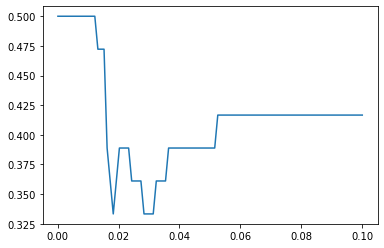

In [95]:
plt.plot(c_vec, acc)

In [96]:
finC = 0.012
fin_clf = LogisticRegression(C = finC, random_state=123456)
fin_clf.fit(X_train_std, y_train)
y_pred = fin_clf.predict(X_test_std)
print('Accuracy: %.2f' % np.round(accuracy_score(y_pred, y_test)*100,2), '%')

Accuracy: 50.00 %


In [97]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Se maximiza la predicción, pero todas las predicciones se realizan en cero,lo cual obedece a un problema de calibración en el modelo... No se toma la medida adecuada para medir el desempeño del modelo.

In [98]:
print(np.unique(y_pred))

[0]


In [99]:
pd.crosstab(y_pred, y_test).reset_index()

col_0,row_0,0,1
0,0,18,18


In [100]:
X_combin = np.vstack((X_train_std, X_test_std))
y_combin = np.hstack((y_train, y_test))

In [101]:
clase = pd.concat([pd.DataFrame(X_combin, columns = ['med1', 'med2']), pd.DataFrame(dict(clase = y_combin))],axis = 1).groupby('clase')
label = ['Positivo', 'Negativo']

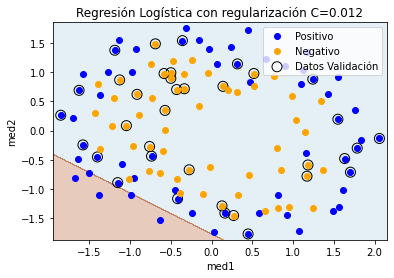

In [102]:
colo = ['blue', 'orange']
fig, ax = plt.subplots()
plot_boundary_cal(fin_clf, X_combin, grid_step=.01)
for nombre, group in clase:
    ax.plot(group.med1, group.med2, marker='o', linestyle='', ms=6, label=label[nombre], c = colo[nombre])
ax.scatter(X_test_std[:,0], X_test_std[:,1],
            c='', edgecolor='black', alpha=1.0,
            linewidth=1, marker='o',
            s=100, label='Datos Validación')
plt.xlabel("med1")
plt.ylabel("med2")
plt.title('Regresión Logística con regularización C=%s' % finC)
ax.legend(loc = 0)

## Uso de otras medidas de desempeño para clasificación

In [43]:
## Precisión de la clasificación por scikit-learn
from sklearn.metrics import log_loss, roc_auc_score

In [103]:
c_vec = np.linspace(0.1,0.5, 100)
acc = []
auc= []
for c in c_vec:
    lr_clf = LogisticRegression(C = c, random_state=123456)
    lr_clf.fit(X_train_std, y_train)
    y_pred = lr_clf.predict(X_test_std)
    acc.append(log_loss(y_pred, y_test))
    auc.append(roc_auc_score(y_pred, y_test))

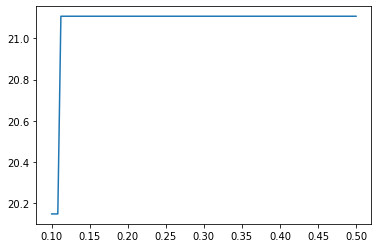

In [104]:
## Gráfica de Calibración parámetro C según Los_loss
plt.plot(c_vec, acc)

In [46]:
c_vec[np.argmax(acc)]

0.11212121212121212

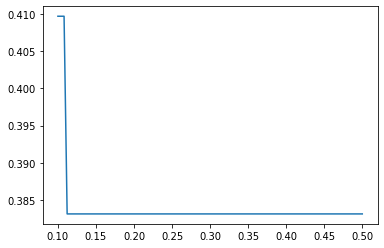

In [47]:
## Gráfica de Calibración parámetro C según Curva ROC (AUC)
plt.plot(c_vec, auc)

In [48]:
c_vec[np.argmax(auc)]

0.1

In [105]:
finC = c_vec[np.argmax(acc)]
finROC = c_vec[np.argmax(auc)]
fin_clf = LogisticRegression(C = finC, random_state=123456)
fin_clf.fit(X_train_std, y_train)
y_pred = fin_clf.predict(X_test_std)
print('Accuracy: %.2f' % np.round(accuracy_score(y_pred, y_test)*100,2), '%')

Accuracy: 38.89 %


AUC: 0.47


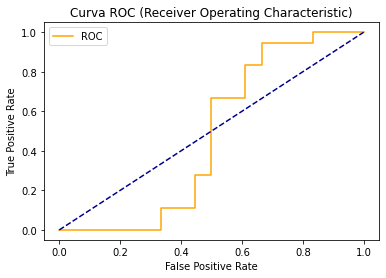

In [106]:
### Graficando Curva ROC
# importar funciones
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predecir las probabilidades para el hold-out
probs = fin_clf.predict_proba(X_test_std)
# Mantener las probabilidades de la clase positiva (1)
probs = probs[:, 1]
# Calcular el AUC (Área bajo la curva ROC)
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)
# Obtener la curva ROC
fpr, tpr, umbral = roc_curve(y_test, probs)
# Graficar la curva ROC
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend()
plt.show()

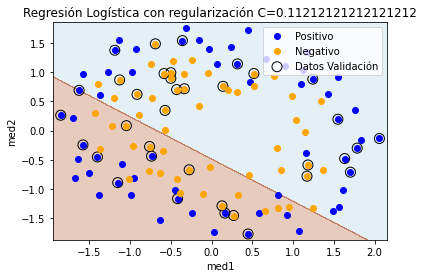

In [107]:
colo = ['blue', 'orange']
fig, ax = plt.subplots()
plot_boundary_cal(fin_clf, X_combin, grid_step=.01)
for nombre, group in clase:
    ax.plot(group.med1, group.med2, marker='o', linestyle='', ms=6, label=label[nombre], c = colo[nombre])
ax.scatter(X_test_std[:,0], X_test_std[:,1],
            c='', edgecolor='black', alpha=1.0,
            linewidth=1, marker='o',
            s=100, label='Datos Validación')
plt.xlabel("med1")
plt.ylabel("med2")
plt.title('Regresión Logística con regularización C=%s' % finC)
ax.legend(loc = 0)

+ El modelo anterior con *log-loss*, clasifica 14 datos de validación de manera correcta: $\frac{14}{36}=0.3889$
+ El modelo anterior con *AUC*, clasifica 15 datos de validación de manera correcta: $\frac{15}{36}=0.4167$

### **RETO**:
1. Construir el código que calibre el parámetro **d** del modelo.
2. Construir el código que calibre el parámetro **d y c** del modelo.

# K-Nearest Classifier

In [6]:
### importar las librerías
from sklearn import neighbors, model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [7]:
datos.head()

,med1,med2,clase
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [8]:
X.head()

,med1,med2
0,0.051267,0.69956
1,-0.092742,0.68494
2,-0.213710,0.69225
3,-0.375000,0.50219
4,-0.513250,0.46564


In [9]:
y[:6]

array([1, 1, 1, 1, 1, 1])

In [10]:
#### Estrategia de hold-out para Validación Cruzada
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state=123456, stratify=y)

In [11]:
y_test.shape

(36,)

In [12]:
### Estandarizar los datos para usar el algoritmo basado en distancias
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)

In [13]:
X_test_std = sc.transform(X_test)

In [14]:
X_test_std[:,1].mean()

0.06827793314616477

In [38]:
%matplotlib inline
from ipywidgets import *

def knnSim(k):
    knn_cla = neighbors.KNeighborsClassifier(n_neighbors=int(k))
    knn_fit = knn_cla.fit(X_train, y_train)
    knn_predict = knn_fit.predict(X_train)
    print('AUC: %.2f' % np.round(roc_auc_score(knn_predict, y_train)*100,2), '%')
    plot_boundary_cal(knn_fit, X_train.values, grid_step=.01)
    plt.scatter(X_train.values[y_train == 1,0], X_train.values[y_train == 1,1], c='orange', label='Positivo')
    plt.scatter(X_train.values[y_train == 0,0], X_train.values[y_train == 0,1], c='blue', label='Negativo')
    plt.xlabel("med1")
    plt.ylabel("med2")
    plt.legend()

interact(knnSim, k = widgets.FloatSlider(value=20, min=1, max=50, step=1, readout_format='.1f'))

interactive(children=(FloatSlider(value=20.0, description='k', max=50.0, min=1.0, readout_format='.1f', step=1…

<function __main__.knnSim(k)>

In [15]:
##### Entrenar el algoritmo

#1. Inicializar el clasificador
knn_clas = neighbors.KNeighborsClassifier()

In [16]:
#2. Definir las metricas de desempeño
acc_scorer = make_scorer(roc_auc_score, greater_is_better=True)

In [17]:
#3. La grilla de los parámetros de validación cruzada
param = {'n_neighbors': np.arange(1,20)}

In [18]:
#4. Inicializar la grilla de validación cruzada
n_folds = 5 ### k-fold CV

grid_obj = GridSearchCV(estimator = knn_clas, param_grid = param, scoring = acc_scorer,
                       n_jobs = -1, cv = n_folds, return_train_score = True)

In [19]:
grid_obj

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             return_train_score=True, scoring=make_scorer(roc_auc_score))

In [20]:
#5. Ajustar a los datos
knnFit = grid_obj.fit(X_train_std, y_train)

In [21]:
#6. Extraer los resultados
res = pd.DataFrame(grid_obj.cv_results_)

In [22]:
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001504,0.000253,0.008281,0.004640,1,{'n_neighbors': 1},0.597222,0.770833,0.4375,0.5625,...,0.586111,0.107188,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.001364,0.000409,0.007114,0.003944,2,{'n_neighbors': 2},0.465278,0.576389,0.5625,0.6250,...,0.570833,0.058498,9,0.812500,0.734375,0.828125,0.796875,0.765625,0.787500,0.033657
2,0.002882,0.003479,0.004415,0.000134,3,{'n_neighbors': 3},0.597222,0.826389,0.6875,0.6250,...,0.622222,0.146763,2,0.846591,0.800189,0.851103,0.774816,0.849265,0.824393,0.031204
3,0.001150,0.000013,0.008041,0.004662,4,{'n_neighbors': 4},0.590278,0.631944,0.7500,0.5625,...,0.619444,0.070053,4,0.814394,0.798295,0.786765,0.800551,0.801471,0.800295,0.008801
4,0.001180,0.000033,0.007698,0.006097,5,{'n_neighbors': 5},0.604167,0.708333,0.7500,0.6250,...,0.625000,0.107851,1,0.831913,0.769413,0.805147,0.774816,0.819853,0.800228,0.024530


In [23]:
#7. Best Alg
bestK = knnFit.best_params_

In [24]:
bestK

{'n_neighbors': 5}

In [25]:
best2 = knnFit.best_estimator_

In [26]:
best2

KNeighborsClassifier()

In [27]:
y_hat = best2.predict(X_test_std)

In [28]:
y_test

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0])

In [30]:
# Calcular el AUC (Área bajo la curva ROC)
auc = roc_auc_score(y_test, y_hat)
print('El área bajo la curva ROC es: %0.3f' % auc)

El área bajo la curva ROC es: 0.750


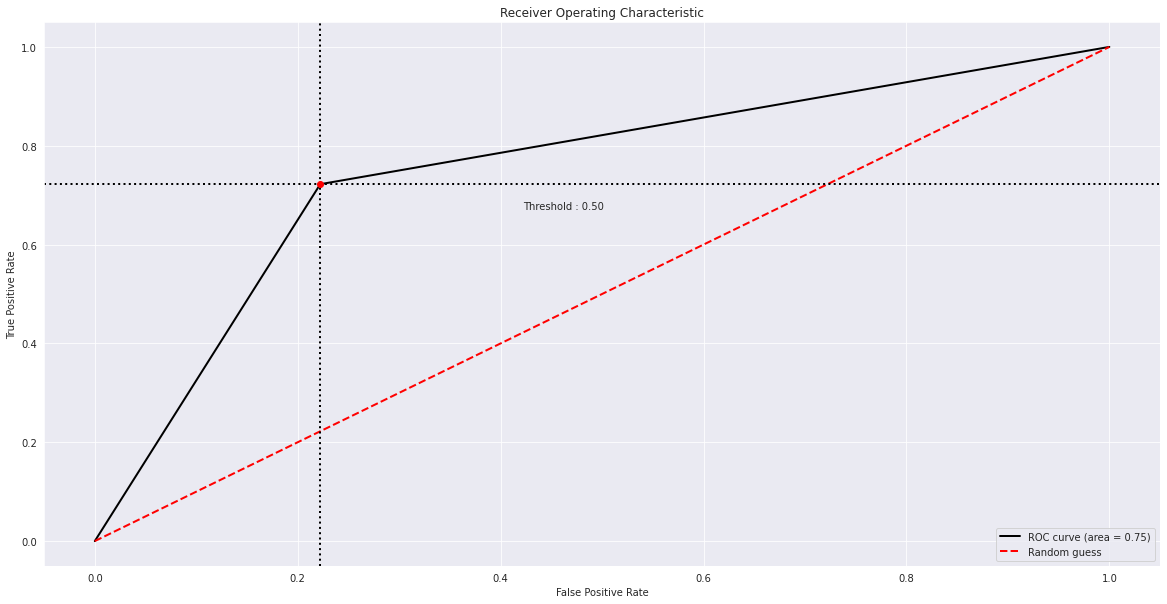

In [34]:
### CURVA ROC
# instalar
# !pip install plot_metric
from plot_metric.functions import BinaryClassification
curva = BinaryClassification(y_test, y_hat, labels=["Clase 1", "Clase 0"])

# plot
plt.figure(figsize=(20,10))
curva.plot_roc_curve()
plt.show()